In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [2]:
contraceptive_data = pd.read_csv("contraceptive/contraceptive_for_students.csv")
contraceptive_data.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [10]:
# Data Cleaning & Necessary Functions
valid_entries = {'wife_education':[1, 2, 3, 4],'husband_education':[1, 2, 3, 4], 'wife_religion':[0,1], 'wife_work':[0,1], 'husband_occupation':[1, 2, 3, 4], 'standard_living':[1, 2, 3, 4], 'media_exposure':[0,1], 'contraceptive':[1,2,3]}
dummy_data = pd.DataFrame.from_dict({'wife_age':[0, 0, 0, 0], 'num_child':[0, 0, 0, 0], 'wife_education':[1, 2, 3, 4],'husband_education':[1, 2, 3, 4], 'wife_religion':[0,1, 0, 1], 'wife_work':[0, 1, 0, 1], 'husband_occupation':[1, 2, 3, 4], 'standard_living':[1, 2, 3, 4], 'media_exposure':[0 , 1, 0, 1]}) # For DictVectorizer

def clean_data(dataset, rename_cols=None):
    dataset = dataset.copy()
    # Remove rows violating constraints
    dataset = dataset.fillna(-1)
    dataset = dataset.astype(int)
    dataset = dataset[(dataset['wife_age']>=0)&(dataset['num_child']>=0)&(dataset['wife_education'].isin(valid_entries['wife_education']))&(dataset['husband_education'].isin(valid_entries['husband_education']))&(dataset['wife_religion'].isin(valid_entries['wife_religion']))&(dataset['wife_work'].isin(valid_entries['wife_work']))&(dataset['husband_occupation'].isin(valid_entries['husband_occupation']))&(dataset['standard_living'].isin(valid_entries['standard_living']))&(dataset['media_exposure'].isin(valid_entries['media_exposure']))&(dataset['contraceptive'].isin(valid_entries['contraceptive']))]
    if rename_cols is not None:
        dataset = dataset.rename(columns=rename_cols)
    return dataset

def split_x_y(dataset, response):
    y = np.array(dataset[response])
    x = dataset.drop(response, axis=1)
    return (x, y)

def one_hot_encode_column(dataset, column_name):
    """
    One-hot-encoder
    """
    dataset = dataset.copy()
    vec_enc = DictVectorizer()
    vec_enc.fit(dataset[[column_name]].to_dict(orient='records'))
    ohe_data = vec_enc.transform(dataset[[column_name]].to_dict(orient='records')).toarray()
    ohe_cats = vec_enc.get_feature_names()
    ohe = pd.DataFrame(ohe_data, columns=ohe_cats)
    dataset = pd.concat([dataset, ohe], axis=1)
    dataset = dataset.drop(column_name, axis=1)
    return dataset

def one_hot_encode(dataset, columns, dummy=None):
    # One-hot encode categorical variables
    dataset = dataset.copy()
    if dummy is not None:
        dataset = dataset.append(dummy, ignore_index=True)
    dataset[columns] = dataset[columns].astype(str)
    for column in columns:
        dataset = one_hot_encode_column(dataset, column)
    if dummy is not None:
        dataset = dataset.iloc[:len(dummy)]
    return dataset

def standardize(dataset, columns):
    # Standardize numerical columns
    dataset = dataset.copy()
    for column in columns:
        if dataset[column].std() > 0:
            dataset[column]=(dataset[column]-dataset[column].mean())/dataset[column].std()
    return dataset

def process_data(dataset, ohe_columns, numerical_columns, response, dummy=None):
    dataset = dataset.copy()
    dataset = clean_data(dataset)
    all_columns = ohe_columns + numerical_columns + [response]
    dataset = dataset[all_columns]
    x, y = split_x_y(dataset, response)
    if numerical_columns:
        x = standardize(x, numerical_columns)
    if ohe_columns:
        x = one_hot_encode(x, ohe_columns)
    return (x, y)

In [19]:
# Data Splitting
cleaned_data = clean_data(contraceptive_data) # Clean data, do not OHE or Standardize until modeling -> EDA first
train, test = train_test_split(cleaned_data, test_size=0.1) # Work only with train data during EDA?
train, val = train_test_split(train, test_size=0.1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [13]:
# Exploratory Data Analysis
numerical = ['wife_age', 'num_child']
categorical = ['wife_education', 'husband_education', 'wife_religion', 'wife_work', 'husband_occupation', 'standard_living', 'media_exposure']
ordinal = ['wife_education', 'husband_education', 'standard_living']
nominal = ['wife_religion', 'wife_work', 'husband_occupation', 'media_exposure']
all_vars = numerical + categorical

In [109]:
# Making a cleaned version of the data for readability and EDA
eda_data = contraceptive_data.copy()
eda_data = clean_data(eda_data)
eda_data = eda_data.rename(columns={"wife_education": "Wife Education", "husband_education": "Husband Education", "contraceptive": "Contraceptive", 'wife_age': "Wife Age", "num_child": "Number of Children", 'wife_religion': 'Wife Religion', 'wife_work': 'Wife Work', 'husband_occupation': "Husband Occupation", "standard_living": "Standard of Living", "media_exposure": "Media Exposure"})
eda_data.head()

,Wife Age,Wife Education,Husband Education,Number of Children,Wife Religion,Wife Work,Husband Occupation,Standard of Living,Media Exposure,Contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


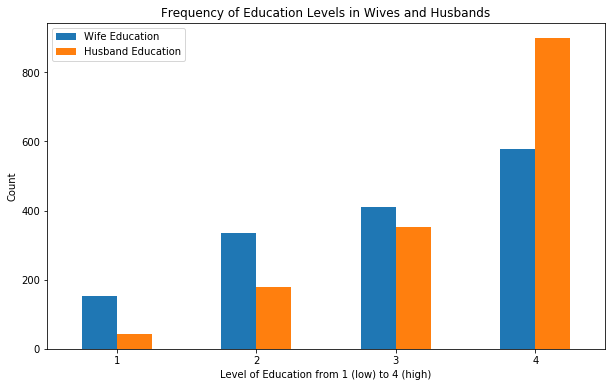

In [110]:
# Wife and Husband Level of Education Counts 
education_counts = pd.DataFrame()
education_counts["Wife Education"] = eda_data["Wife Education"].value_counts(ascending=True)
education_counts["Husband Education"] = eda_data["Husband Education"].value_counts(ascending=True)

education_counts.plot.bar(rot=0, figsize=(10,6))

plt.xlabel('Level of Education from 1 (low) to 4 (high)')
plt.ylabel('Count')
plt.title("Frequency of Education Levels in Wives and Husbands");

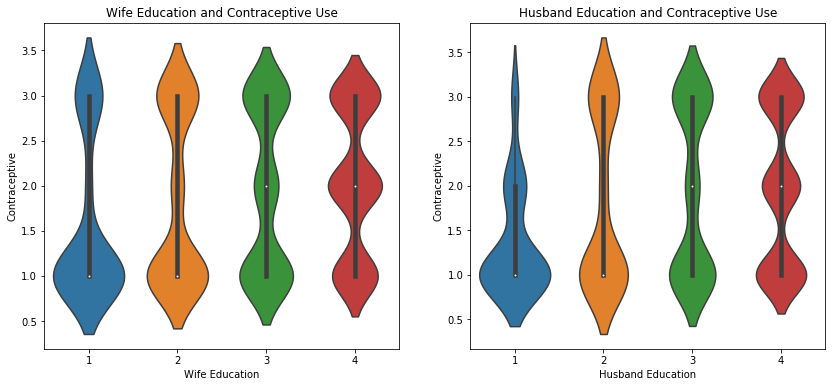

In [111]:
# Wife & Husband Combined Education and Contraceptive Use
combined_edu = eda_data[["Wife Education", "Husband Education", "Contraceptive"]]

f, ax = plt.subplots(1, 2, figsize=(14,6))
sns.violinplot(data=combined_edu, x='Wife Education', y='Contraceptive', ax=ax[0])
sns.violinplot(data=combined_edu, x='Husband Education', y='Contraceptive', ax=ax[1]);

ax[0].set_title("Wife Education and Contraceptive Use")
ax[1].set_title("Husband Education and Contraceptive Use");

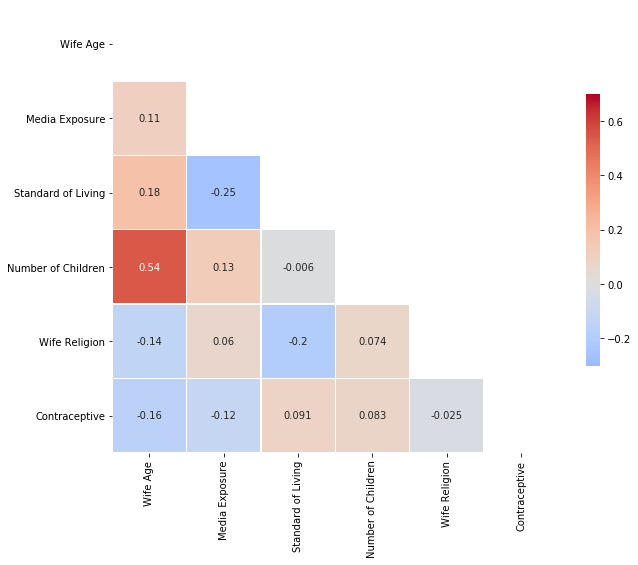

In [112]:
#Heatmap displaying correlation between different features

heatmap_df = eda_data[['Wife Age', 'Media Exposure', 'Standard of Living', 'Number of Children', 'Wife Religion', 'Contraceptive']]
corr = heatmap_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, vmax=0.7, mask=mask, vmin=-0.3, center=0, cmap='coolwarm',
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

**Conclusion:** Number of Children and Wife Age have a very high correlation and could be interpreted as redundancy, so we are choosing not to ignore it.

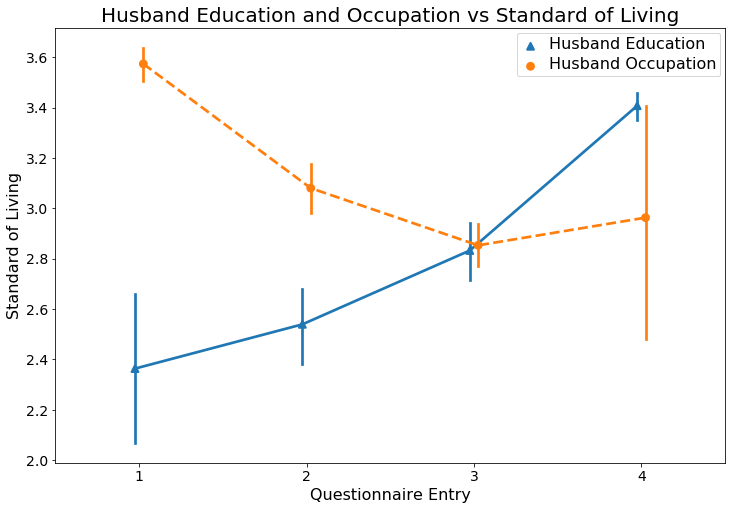

In [113]:
edu_occu_stand = eda_data[['Husband Education', 'Standard of Living']].rename(columns={'Husband Education': 'Questionnaire Entry'})
edu_occu_stand['Metric'] = ['Husband Education' for i in range(1473)]

occu_table = eda_data[['Husband Occupation', 'Standard of Living']].rename(columns={'Husband Occupation': 'Questionnaire Entry'})
occu_table['Metric'] = ['Husband Occupation' for i in range(1473)]

edu_occu_stand = edu_occu_stand.append(occu_table)

fig, ax = plt.subplots(figsize=(12, 8))
sns.pointplot(x="Questionnaire Entry", y="Standard of Living", hue="Metric", markers=["^", "o"], linestyles=["-", "--"], data=edu_occu_stand, ci=95, dodge=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
plt.title("Husband Education and Occupation vs Standard of Living",fontsize=20)
plt.xlabel("Questionnaire Entry",fontsize=16)
plt.ylabel("Standard of Living",fontsize=16)
plt.tick_params(labelsize=14)

In [20]:
# Model Generation - classification task -> Logistic Regression CV, Decision Trees, Random Forest, more?
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
x_train, y_train = process_data(train, categorical, numerical, 'contraceptive', dummy_data)
logistic_model = LogisticRegressionCV(multi_class='ovr')
logistic_model.fit(x_train, y_train)
decisionTree_model = DecisionTreeClassifier()
decisionTree_model.fit(x_train, y_train)
randomForest_model = RandomForestClassifier()
randomForest_model.fit(x_train, y_train)
knn_model = KNeighborsClassifier()
n_neighbors = {'n_neighbors':np.arange(1, 26)}
knn_model_gscv = GridSearchCV(knn_model, n_neighbors, cv=5)
knn_model_gscv.fit(x_train, y_train)
svm_model = SVC()
param_grid = {'C':np.linspace(1, 10, 25)}
svm_model_gscv = GridSearchCV(svm_model, param_grid, cv=5)
svm_model_gscv.fit(x_train, y_train)
models = [logistic_model, decisionTree_model, randomForest_model, knn_model_gscv, svm_model_gscv]
train_scores = [model.score(x_train, y_train) for model in models]
print(train_scores)
x_val, y_val = process_data(val, categorical, numerical, 'contraceptive', dummy_data)
val_scores = [model.score(x_val, y_val) for model in models]
print(val_scores)
chosen_model = models[np.argmax(val_scores)]

[0.5067114093959731, 0.9572147651006712, 0.9572147651006712, 0.5989932885906041, 0.6426174496644296]
[0.48872180451127817, 0.43609022556390975, 0.46616541353383456, 0.556390977443609, 0.5939849624060151]


In [21]:
# Model Testing
x_test, y_test = process_data(test, categorical, numerical, 'contraceptive', dummy_data)
chosen_model.score(x_test, y_test)

0.5067567567567568

In [8]:
# Interpret Results